In [1]:
import torch
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score
from torch_geometric.data import Dataset
from sklearn.metrics import roc_auc_score

import clang.cindex 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configure libclang path
if os.name == 'nt':  # Windows
    print('Windows')
    clang.cindex.Config.set_library_file('D:/Project/LLVM/bin/libclang.dll')
    print(clang.cindex.Config.library_path)
elif os.name == 'posix':  # Linux/Mac
    print('Linux/Mac')
    clang.cindex.Config.set_library_file('/Library/Developer/CommandLineTools/usr/lib/libclang.dylib')
    # clang.cindex.Config.set_library_path('/Library/Developer/CommandLineTools/usr/lib/')
    print(clang.cindex.Config.library_path)

# Verify if libclang is loaded
print(clang.cindex.Config.loaded)  # Should print `True`

Linux/Mac
None
False


In [3]:
def save_ast(node):
    """Store the children of the AST node."""
    node.children = list(node.get_children())
    for child in node.children:
        save_ast(child)

def number_ast_nodes(node, counter=1):
    """Assign unique identifiers to each node in the AST."""
    node.identifier = counter
    counter += 1

    node.children = list(node.get_children())
    for child in node.children:
        counter = number_ast_nodes(child, counter)

    return counter

def generate_edgelist(ast_root):
    """Generate an edge list from the AST."""
    edges = [[], []]

    def walk_tree_and_add_edges(node):
        for child in node.children:
            edges[0].append(node.identifier - 1)
            edges[1].append(child.identifier - 1)
            walk_tree_and_add_edges(child)

    walk_tree_and_add_edges(ast_root)
    return torch.tensor(edges, dtype=torch.long)

def generate_features(ast_root):
    """Generate node features for the AST."""
    features = []

    def walk_tree_and_set_features(node):
        out_degree = len(node.children)
        node_id = node.identifier
        features.append([node_id, out_degree])

        for child in node.children:
            walk_tree_and_set_features(child)

    walk_tree_and_set_features(ast_root)
    return torch.tensor(features, dtype=torch.float)

def clang_process(testcase):
    """Process a test case using Clang to generate AST, edges, and features."""
    parse_list = [(testcase.filename, testcase.code)]

    index = clang.cindex.Index.create()
    translation_unit = index.parse(path=testcase.filename, unsaved_files=parse_list)
    ast_root = translation_unit.cursor

    save_ast(ast_root)
    number_ast_nodes(ast_root)

    edges_embedding = generate_edgelist(ast_root)
    nodes_embedding = generate_features(ast_root)
    y = torch.tensor([testcase.vuln], dtype=torch.int64)

    # Clean up Clang objects
    del translation_unit, ast_root, index

    return Data(x=nodes_embedding, edge_index=edges_embedding, y=y)

In [4]:
class GenDataset(Dataset):
    def __init__(self, root, csv_path, transform=None, pre_transform=None):
        """
        Args:
            root (str): Root directory where processed data will be stored.
            csv_path (str): Path to the CSV file containing the dataset.
            transform: Optional transform to be applied to the data.
            pre_transform: Optional pre-transform to be applied to the data.
        """
        self.csv_path = csv_path
        super(GenDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return []  # No raw files are needed

    @property
    def processed_file_names(self):
        """Return a list of processed file names."""
        if not hasattr(self, 'data'):
            self.data = pd.read_csv(self.csv_path)
        return [f'data_{i}.pt' for i in range(len(self.data))]

    def download(self):
        """No download needed since we are using a local CSV file."""
        pass

    def process(self):
        """Load the CSV file and process each row into a graph."""
        self.data = pd.read_csv(self.csv_path)
        for index, vuln in tqdm(self.data.iterrows(), total=len(self.data)):
            data = clang_process(vuln)
            torch.save(data, os.path.join(self.processed_dir, f'data_{index}.pt'))

    def len(self):
        """Return the number of graphs in the dataset."""
        return len(self.processed_file_names)

    def get(self, idx):
        """Load a graph from disk."""
        return torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'), weights_only=False)

In [5]:
csv_path = "Datasets/Normalized_CWE-469.csv"
dataset = GenDataset(root='processed_data', csv_path=csv_path)

In [6]:
len(dataset)

5250

In [7]:
print(f"Number of features: {dataset[0].num_features}")

Number of features: 2


In [8]:
tmpData = dataset[2] # Get the first graph object
print(f"Number of edges: {tmpData.num_edges}")
print(f"Number of nodes: {tmpData.num_nodes}")

Number of edges: 4
Number of nodes: 5


In [9]:
print(dataset[2].edge_index.t())

tensor([[0, 1],
        [1, 2],
        [1, 3],
        [1, 4]])


In [10]:
print(dataset[2].x)

tensor([[1., 1.],
        [2., 3.],
        [3., 0.],
        [4., 0.],
        [5., 0.]])


In [11]:
print(dataset[2].y)

tensor([0])


### Split dataset into training and validation sets

In [12]:
data = dataset.shuffle()
one_tenth_length = int(len(data) * 0.1)
train_dataset = data[:one_tenth_length * 8]
val_dataset = data[one_tenth_length * 8 : one_tenth_length * 9]
test_dataset = data[one_tenth_length * 9:]

In [13]:
len(train_dataset), len(val_dataset), len(test_dataset)

(4200, 525, 525)

In [14]:
from torch_geometric.data import DataLoader
NUM_OF_GRAPHS_PER_BATCH = 64
train_dataset_loader = DataLoader(train_dataset, batch_size=NUM_OF_GRAPHS_PER_BATCH, shuffle=True, drop_last=True)
val_dataset_loader = DataLoader(val_dataset, batch_size=NUM_OF_GRAPHS_PER_BATCH, shuffle=True, drop_last=True)
test_dataset_loader = DataLoader(test_dataset, batch_size=NUM_OF_GRAPHS_PER_BATCH, shuffle=True, drop_last=True)

# NUM_OF_GRAPHS_PER_BATCH = 64  # Reduce batch size for better training updates

# train_dataset_loader = DataLoader(train_dataset, batch_size=NUM_OF_GRAPHS_PER_BATCH, shuffle=True, drop_last=True)
# val_dataset_loader = DataLoader(val_dataset, batch_size=NUM_OF_GRAPHS_PER_BATCH, shuffle=False, drop_last=False)
# test_dataset_loader = DataLoader(test_dataset, batch_size=NUM_OF_GRAPHS_PER_BATCH, shuffle=False, drop_last=False)

/opt/homebrew/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## GNN model

In [32]:
import torch
from torch.nn import Linear, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool as gap, global_max_pool as gmp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Hyperparameters
embedding_size = 128
dropout_rate = 0.3
learning_rate = 0.001
patience = 10
num_epochs = 100

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(dataset.num_features, embedding_size) #to  translate our node features into the size of the embedding
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        # pooling layer
        #self.pool = TopKPooling(embedding_size, ratio=0.8)
        #dropout layer
        #self.dropout = Dropout(p=0.2)

        # Output layer
        self.lin1 = Linear(embedding_size*2, 128) # linear output layer ensures that we get a continuous unbounded output value. It input is the flattened vector (embedding size *2) from the pooling layer (mean and max)
        self.lin2 = Linear(128, 128)
        self.lin3 = Linear(128, 1)
        

        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)

        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)
        #hidden = self.dropout(hidden)
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)
        # Apply a final (linear) classifier.
        out = self.lin1(hidden)
        out = self.act1(out)
        out = self.lin2(out)
        out = self.act2(out)
        #out = F.dropout(out, p=0.5, training=self.training)
        out = self.lin3(out)
        out = torch.sigmoid(out)

        # return out, hidden
        return out

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize model
#model = GCN(num_features=dataset.num_features).to(device)
model = GCN().to(device)
# Update optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
loss_fn = torch.nn.BCELoss()

# Training function
def train():
    model.train()

    loss_all = 0
    for data in train_dataset_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x.float(), data.edge_index, data.batch)
        label = data.y.to(device)
        #loss = torch.sqrt(loss_fn(output, label))  
        loss = loss_fn(output.squeeze(), label.float())  
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)

# Evaluation function
def evaluate(loader):
    model.eval()

    predictions = []
    labels = []

    with torch.no_grad():
        for data in loader:

            data = data.to(device)
            # pred = model(data.x.float(), data.edge_index, data.batch).detach().cpu().numpy()
            pred = model(data.x.float(), data.edge_index, data.batch)
            label_true = data.y.to(device)
            label = data.y.detach().cpu().numpy()
            # predictions.append(pred)
            # labels.append(label)
            predictions.append(np.rint(pred.cpu().detach().numpy()))
            labels.append(label)
            loss = loss_fn(pred.squeeze(), label_true.float())
    # predictions = np.hstack(predictions)
    # labels = np.hstack(labels)
    predictions = np.concatenate(predictions).ravel()
    labels = np.concatenate(labels).ravel()

    # print(predictions)
    # print(labels)
    return accuracy_score(labels, predictions), loss

In [33]:
# Lists to store metrics for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop with early stopping
best_val_loss = float('inf')
early_stop_counter = 0

print("Starting training...")
for epoch in range(num_epochs):
    train_loss = train()
    train_acc, _ = evaluate(train_dataset_loader)
    val_acc, val_loss = evaluate(val_dataset_loader)

    scheduler.step(val_loss)

    # Store metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break

print(f"Training finished. Best validation loss: {best_val_loss:.4f}")

Starting training...
Epoch   1 | Train Loss: 0.6135 | Train Acc: 0.7036 | Val Acc: 0.7070 | Val Loss: 0.5834
Epoch   2 | Train Loss: 0.5803 | Train Acc: 0.7053 | Val Acc: 0.7207 | Val Loss: 0.5883
Epoch   3 | Train Loss: 0.5819 | Train Acc: 0.7031 | Val Acc: 0.7168 | Val Loss: 0.5448
Epoch   4 | Train Loss: 0.5747 | Train Acc: 0.7014 | Val Acc: 0.7285 | Val Loss: 0.5724
Epoch   5 | Train Loss: 0.5742 | Train Acc: 0.6635 | Val Acc: 0.7070 | Val Loss: 0.5307
Epoch   6 | Train Loss: 0.5822 | Train Acc: 0.6954 | Val Acc: 0.7031 | Val Loss: 0.5083
Epoch   7 | Train Loss: 0.5735 | Train Acc: 0.7014 | Val Acc: 0.7285 | Val Loss: 0.5159
Epoch   8 | Train Loss: 0.5748 | Train Acc: 0.7019 | Val Acc: 0.7266 | Val Loss: 0.6279
Epoch   9 | Train Loss: 0.5748 | Train Acc: 0.7041 | Val Acc: 0.7266 | Val Loss: 0.4696
Epoch  10 | Train Loss: 0.5728 | Train Acc: 0.7017 | Val Acc: 0.7129 | Val Loss: 0.6047
Epoch  11 | Train Loss: 0.5745 | Train Acc: 0.7000 | Val Acc: 0.7070 | Val Loss: 0.6073
Epoch  12 |

### Ploting learning curve

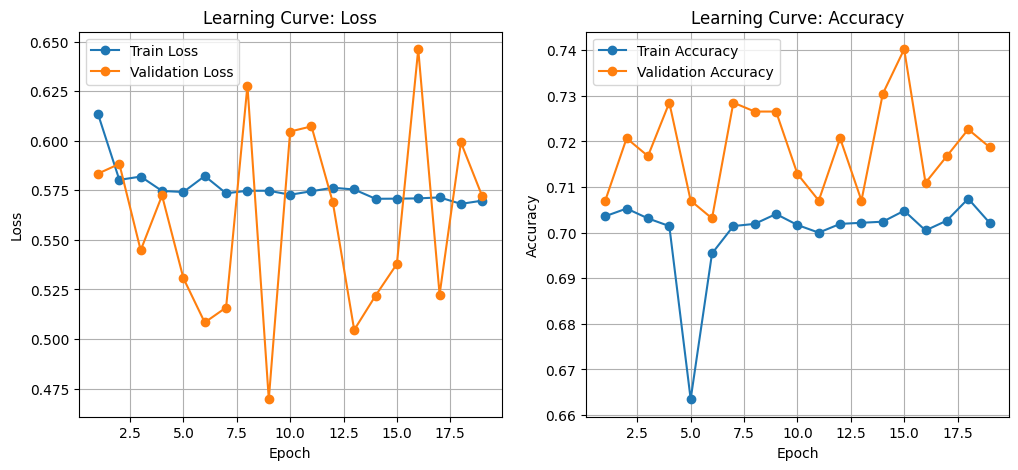

In [34]:
# Plot Loss Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve: Loss")
plt.legend()
plt.grid()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", marker="o")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Learning Curve: Accuracy")
plt.legend()
plt.grid()

# Show plots
plt.show()

In [35]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

NUM_GRAPHS_PER_BATCH_1 = len(test_dataset)
test_loader_all = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH_1, drop_last=False, shuffle=True)

# Analyze the results for all graphs
test_batch = next(iter(test_loader_all))
test_batch = test_batch.to(device)  # Move to device

with torch.no_grad():
    # Forward pass
    pred = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)

    # Convert predictions to binary (0 or 1)
    pred_bin = np.rint(pred.cpu().numpy())  # Convert tensor → NumPy → Rounded binary values
    y_true = test_batch.y.cpu().numpy()  # Convert tensor → NumPy

    # Compute evaluation metrics
    accuracy = accuracy_score(y_true, pred_bin)
    precision = precision_score(y_true, pred_bin, zero_division=1)
    recall = recall_score(y_true, pred_bin, zero_division=1)
    f1 = f1_score(y_true, pred_bin)

    # Print confusion matrix
    print(f"\n Confusion matrix: \n {confusion_matrix(y_true, pred_bin)}")
    print(f"\n Accuracy: {accuracy:.4f}")
    print(f"\n Precision: {precision:.4f}")
    print(f"\n Recall: {recall:.4f}")
    print(f"\n F1 Score: {f1:.4f}")

    # Save results in a DataFrame
    df = pd.DataFrame({
        "y_real": y_true.tolist(),
        "y_pred": pred_bin.tolist()
    })

df  # Display DataFrame


/opt/homebrew/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



 Confusion matrix: 
 [[180  82]
 [ 64 199]]

 Accuracy: 0.7219

 Precision: 0.7082

 Recall: 0.7567

 F1 Score: 0.7316


,y_real,y_pred
0,0,[0.0]
1,1,[1.0]
2,0,[0.0]
3,1,[0.0]
4,1,[1.0]
...,...,...
520,1,[1.0]
521,1,[1.0]
522,0,[1.0]
523,0,[0.0]
